In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import pickle
import enum
from tqdm import tqdm_notebook
import torchvision


## High-dimensional data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

mnist_path = '/content/drive/My Drive/Colab Notebooks/mnist-hw1.pkl'

with open(mnist_path, 'rb') as f:
    dataset = pickle.load(f)

train = dataset['train']
test = dataset['test']

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


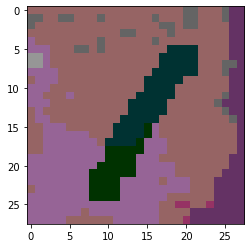

In [0]:
plt.imshow(train[3] * 50);

In [0]:
def swap_channels(data):
    return data.transpose(0, 3, 1, 2)

train = swap_channels(train)
test = swap_channels(test)
print(train.shape)

(60000, 3, 28, 28)


In [0]:
class Type(enum.Enum):
    A = 1
    B = 2

class MaskedCNN(torch.nn.Conv2d):
    def __init__(self, conv_type, *args, **kwargs):
        super().__init__(*args, **kwargs)    
        self.register_buffer('mask', torch.ones_like(self.weight))
        h, w = self.weight.shape[2:]
        self.mask[:, :, h // 2 + 1:, :] = 0
        self.mask[:, :, h // 2, w // 2:] = 0
        
        if conv_type == Type.B:
            self.mask[:, :, h // 2, w // 2] = 1
    
    def forward(self, X):
        self.weight.data *= self.mask
        return super(MaskedCNN, self).forward(X)
    
    
class ResidualBlock(torch.nn.Module):
    def __init__(self, h):
        super(ResidualBlock, self).__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(2 * h, h, 1),
            torch.nn.BatchNorm2d(h),
            torch.nn.ReLU(),
            MaskedCNN(Type.B, h, h, 3, padding=1),
            torch.nn.BatchNorm2d(h),
            torch.nn.ReLU(),
            torch.nn.Conv2d(h, 2 * h, 1),
            torch.nn.BatchNorm2d(2 * h),
            torch.nn.ReLU(),
        )
        
    def forward(self, X):
        return self.model(X) + X

    
class PixelCnn(torch.nn.Module):
    
    def __init__(self, h):
        super(PixelCnn, self).__init__()
        
        residuals = [ResidualBlock(h) for _ in range(12)]
        
        self.model = torch.nn.Sequential(
            MaskedCNN(Type.A, 3, h * 2, 7, stride=1, padding=3),
            torch.nn.BatchNorm2d(2 * h),
            *residuals,
            torch.nn.Conv2d(2 * h, 2 * h, 1),
            torch.nn.BatchNorm2d(2 * h),
            torch.nn.ReLU(),
            torch.nn.Conv2d(2 * h, 3 * 4, 1)
        )
        
        self.softmax = torch.nn.Softmax(dim=-1)
    
    def forward(self, X):
        x = X.float()
        n, c, h, w = x.shape
        out = self.model(x)
        out = out.reshape(n, c, 4, h, w)
        out = out.permute(0, 1, 3, 4, 2)
        
        out = self.softmax(out)
        X = X.long()
        probs = torch.gather(out, 4, X.view(n, c, h, w, 1))
        return probs, out

def get_loss(probs):
    return -torch.log2(probs).mean()

In [0]:
batch_size = 128
num_epochs = 20
h = 128

train_batches = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_batches = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False) 
test = torch.tensor(test)

model = PixelCnn(h)
model.to(device)
path = "/content/drive/My Drive/Colab Notebooks/model.data"
# model.load_state_dict(torch.load(path))
# model.eval()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

In [0]:
for epoch in range(num_epochs):
    loss = 0
    for batch in tqdm_notebook(train_batches):
        optimizer.zero_grad()
        batch = batch.to(device)
        outputs, _ = model(batch)
        cur_loss = get_loss(outputs)
        loss += cur_loss.item()
        cur_loss.backward()
        optimizer.step()
        
    train_losses.append(loss / (len(train) / batch_size))
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm_notebook(test_batches):
            batch = batch.to(device)
            outputs, _ = model(batch)
            val_loss += get_loss(outputs).item()

    val_losses.append(val_loss / (len(test) / batch_size))
    torch.save(model.state_dict(), f"/content/drive/My Drive/Colab Notebooks/model_{epoch}.data")
    
    print(f'Epoch {epoch}: training loss {train_losses[-1]}, validation loss {val_losses[-1]}')


Epoch 0: training loss 0.25437629566192627, validation loss 0.16544911785125732



Epoch 1: training loss 0.14908381106058757, validation loss 0.14491757068634034



Epoch 2: training loss 0.1388770559946696, validation loss 0.1393306257247925



Epoch 3: training loss 0.13426463483174642, validation loss 0.1360895245552063



Epoch 4: training loss 0.13121731791496277, validation loss 0.13319539651870727



Epoch 5: training loss 0.128717453956604, validation loss 0.13070658960342407



Epoch 6: training loss 0.12653648498853048, validation loss 0.129432315826416



Epoch 7: training loss 0.12493433415095011, validation loss 0.12755810127258302



Epoch 8: training loss 0.12361380012830099, validation loss 0.12731179580688476



Epoch 9: training loss 0.12243140303293865, validation loss 0.12617298574447633



Epoch 10: training loss 0.12148529879252117, validation loss 0.12602931356430053



Epoch 11: training loss 0.12059388276735941, validation loss 0.12508080339431762



Epoch 12: training loss 0.11977661797205608, validation loss 0.12418033666610717



Epoch 13: training loss 0.11897862119674682, validation loss 0.12434007902145386


In [0]:
plt.plot(np.arange(len(val_losses)), val_losses)
plt.plot(np.linspace(0, len(val_losses), len(train_losses)), train_losses)
plt.legend(('validation','train'));

NameError: ignored

In [0]:
def sample(model, N):
        x = torch.zeros((N, 3, 28, 28)).to(device)
        with torch.no_grad():
            for i in tqdm_notebook(range(28)):
                for j in range(28):
                    for k in range(3):
                        _, dist = model(x)
                        for n in range(N):
                            x[n, k, i, j] = np.random.choice(4, p=dist[n, k, i, j].detach().cpu().numpy())
        return x


pics = sample(model, 100)

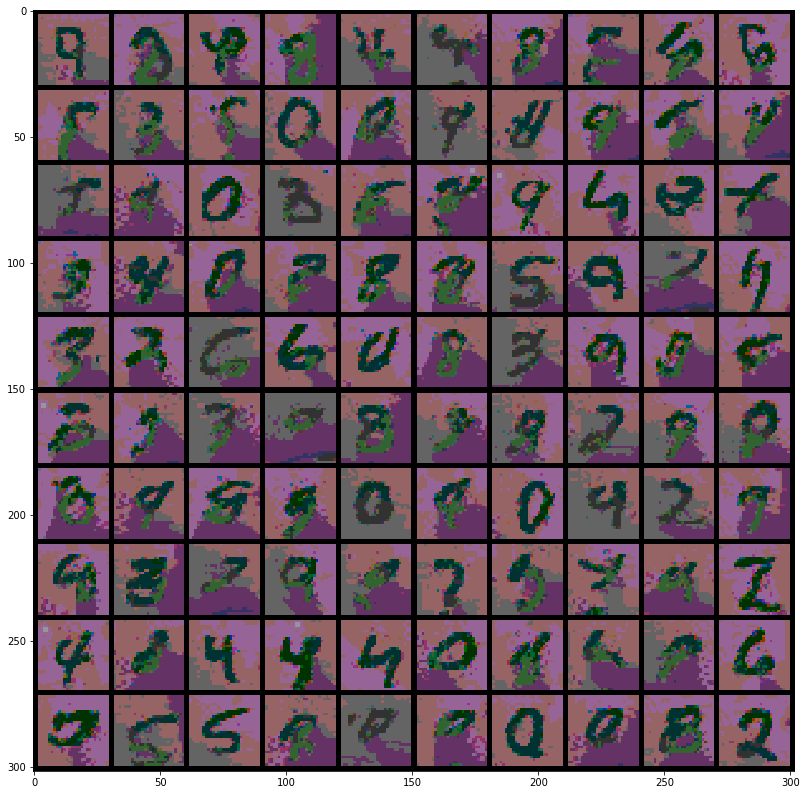

In [0]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=[14, 14])
    plt.imshow(np.transpose(npimg, (1, 2, 0)) * 50)
    plt.show()

grid = torchvision.utils.make_grid(pics.long(), nrow=10)
imshow(grid)

In [0]:
def receptive_field():
    optimizer.zero_grad()
    cnn = PixelCnn(h)
    x = torch.tensor(test[:batch_size].float(), requires_grad=True)
    out, _ = cnn(x)
    
    loss = get_loss(out[:, 0, 14, 14])
    loss.backward()
    grad = torch.sum(x.grad.abs(), dim=(0, 1))
    plt.imshow(grad)
    
receptive_field()

In [0]:
device

device(type='cuda', index=0)

## Now let's introduce MADE

In [0]:
class MadeMaskedCNN(torch.nn.Conv2d):

    before=None

    def __init__(self, conv_type, *args, **kwargs):
        super().__init__(*args, **kwargs)    
        self.register_buffer('mask', torch.ones_like(self.weight))
        n, c, h, w = self.weight.shape
        self.mask[:, :, h // 2 + 1:, :] = 0
        self.mask[:, :, h // 2, w // 2:] = 0
        
        if conv_type == Type.B:
            if MadeMaskedCNN.before is None:
                MadeMaskedCNN.before = np.random.permutation(np.arange(1, c + 1))
            
            after = np.random.randint(MadeMaskedCNN.before.min(), 3, size=n)
            # print(MadeMaskedCNN.before.shape, )
            made = MadeMaskedCNN.before[None, :] < after[:, None]
            made = torch.tensor(made, device=device).float()
            print(made)
            self.mask[:, :, h // 2, w // 2] = made
            MadeMaskedCNN.before = after
    
    def forward(self, X):
        self.weight.data *= self.mask
        return super(MadeMaskedCNN, self).forward(X)
    
    
class MadeResidualBlock(torch.nn.Module):
    def __init__(self, h):
        super(MadeResidualBlock, self).__init__()
        
        self.model = torch.nn.Sequential(
            MadeMaskedCNN(Type.B, 2 * h, h, 1),
            torch.nn.BatchNorm2d(h),
            torch.nn.ReLU(),
            MadeMaskedCNN(Type.B, h, h, 3, padding=1),
            torch.nn.BatchNorm2d(h),
            torch.nn.ReLU(),
            MadeMaskedCNN(Type.B, h, 2 * h, 1),
            torch.nn.BatchNorm2d(2 * h),
            torch.nn.ReLU(),
        )
        
    def forward(self, X):
        return self.model(X) + X

    
class MadePixelCnn(torch.nn.Module):
    
    def __init__(self, h):
        super(MadePixelCnn, self).__init__()
        
        residuals = [MadeResidualBlock(h) for _ in range(12)]

        self.model = torch.nn.Sequential(
            MadeMaskedCNN(Type.A, 3, h * 2, 7, stride=1, padding=3),
            torch.nn.BatchNorm2d(2 * h),
            *residuals,
            MadeMaskedCNN(Type.B, 2 * h, 2 * h, 1),
            torch.nn.BatchNorm2d(2 * h),
            torch.nn.ReLU(),
            MadeMaskedCNN(Type.B, 2 * h, 3 * 4, 1)
        )
        
        self.softmax = torch.nn.Softmax(dim=-1)
    
    def forward(self, X):
        x = X.float()
        n, c, h, w = x.shape
        out = self.model(x)
        out = out.reshape(n, c, 4, h, w)
        out = out.permute(0, 1, 3, 4, 2)
        
        out = self.softmax(out)
        X = X.long()
        probs = torch.gather(out, 4, X.view(n, c, h, w, 1))
        return probs, out

In [0]:
batch_size = 128
num_epochs = 20
h = 128

made_model = MadePixelCnn(h)
made_model.to(device)
path = "/content/drive/My Drive/Colab Notebooks/model.data"
# model.load_state_dict(torch.load(path))
# model.eval()

optimizer = torch.optim.Adam(made_model.parameters(), lr=0.001)

train_losses = []
val_losses = []

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([[0., 1., 0.,  ..., 1., 1., 0.],
        [0., 1., 0.,  ..., 1., 1., 0.],
        [0., 1., 0.,  ..., 1., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 1.],
        [1., 0., 0.,  ..., 1., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0

In [0]:
for epoch in range(num_epochs):
    loss = 0
    for batch in tqdm_notebook(train_batches):
        optimizer.zero_grad()
        batch = batch.to(device)
        outputs, _ = made_model(batch)
        cur_loss = get_loss(outputs)
        loss += cur_loss.item()
        cur_loss.backward()
        optimizer.step()
        
    train_losses.append(loss / (len(train) / batch_size))
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm_notebook(test_batches):
            batch = batch.to(device)
            outputs, _ = made_model(batch)
            val_loss += get_loss(outputs).item()

    val_losses.append(val_loss / (len(test) / batch_size))
    torch.save(model.state_dict(), f"/content/drive/My Drive/Colab Notebooks/model_{epoch}.data")
    
    print(f'Epoch {epoch}: training loss {train_losses[-1]}, validation loss {val_losses[-1]}')


Epoch 0: training loss 1.5563183446248372, validation loss 1.3677765625



Epoch 1: training loss 1.3203138720194498, validation loss 1.3305872512817383



Epoch 2: training loss 1.313158768717448, validation loss 1.3299024398803712



Epoch 3: training loss 1.312971917215983, validation loss 1.32992919921875


KeyboardInterrupt: ignored

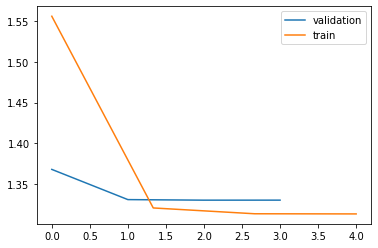

In [0]:
plt.plot(np.arange(len(val_losses)), val_losses)
plt.plot(np.linspace(0, len(val_losses), len(train_losses)), train_losses)
plt.legend(('validation','train'));

In [0]:
pics = sample(made_model, 100)
grid = torchvision.utils.make_grid(pics.long(), nrow=10)
imshow(grid)